##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pix2Pix 512x512

    A modified verision of the Tensorflow Pix2Pix to accomidate for 512x512 images.
    Find the original here: 
    https://www.tensorflow.org/tutorials/generative/pix2pix
    
    I will express clearly which bits of code I have altered with :
    
   # <<<<<<<<<<<<<<<<
   
   
    This is also mainly an explination Doc but it does run the training program, I found that
    with jupiter notebook the program would crash after 15-20 epocs due to it's memory managment
    problems so I would normally run it through the streamLined .PY in this folder.

## Import TensorFlow and other libraries

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display


physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

AssertionError: Not enough GPU hardware devices available

## Load the dataset

Loading in data-set from path on my computer, the process as follows:


In [2]:

#3dCrystals
PATH = '/home/gimms/Desktop/temp/old data/'

In [3]:
BUFFER_SIZE = 600
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512

###  Loading and splitting the images into pairs and casting them to tensors.

In [4]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

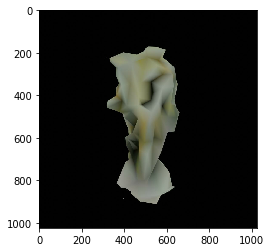

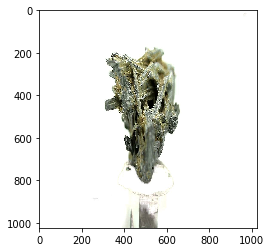

In [5]:
inp, re = load(PATH+'train/0100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

### Resize, random crop and randomly flip the image set to add variences to the data set.

In [6]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [8]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, int(IMG_WIDTH*1.2), int(IMG_HEIGHT*1.2))

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

### Notmaslize the tensor between -1 and 1

In [9]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

### See below the outcome of the jitter function

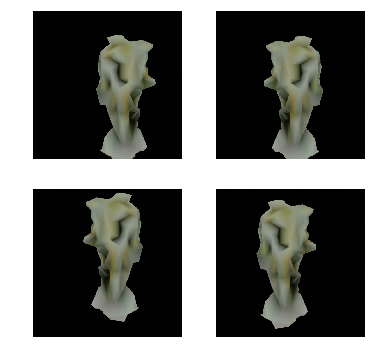

In [10]:


plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

### Collective loading functions to apply the previous functions all together to each image


In [11]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [12]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  
   
    
  return input_image, real_image

### Input Pipeline, mapping a tensor of images to the necessary loading functions

In [13]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
#to unrandomise the shuffle add false, this is if you want a running animation or something
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg' )#, shuffle=False)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [17]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

# <<<<<<<<<<<<<<<<
## Modified the U-Net architecture for a tensor of 512x512

    I did this by adding in a layer at each up and down stack of the U-Net, as well as 
    changing the dimensions of many of the layers. In my research I built a model for 
    1024x1024 and saw a few 512x512 models with many more hidden layers, but as I was 
    aiming to train these models on my computer for ease and speed these where not an
    option for this project, as they where far to big for my hardware. 
    
    Here is the original 256x256 up/down stack from the pix2pix U-Net by tensorflow as a comparison:
    
      down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

      up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
# <<<<<<<<<<<<<<<<

In [18]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3])

  down_stack = [ 
    downsample(32, 4, apply_batchnorm=False), # (bs, 256, 256, 32)
    downsample(64, 4), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(1024, 4), # (bs, 8, 8, 1024)
    downsample(1024, 4), # (bs, 4, 4, 1024)
    downsample(1024, 4), # (bs, 2, 2, 1024)
    downsample(1024, 4), # (bs, 1, 1, 1024)
  ]

  up_stack = [
    upsample(1024, 4, apply_dropout=True), # (bs, 2, 2, 2048)
    upsample(1024, 4, apply_dropout=True), # (bs, 4, 4, 2048)
    upsample(1024, 4, apply_dropout=True), # (bs, 8, 8, 2048)
    upsample(512, 4), # (bs, 16, 16, 2048)
    upsample(256, 4), # (bs, 32, 32, 1024)
    upsample(128, 4), # (bs, 64, 64, 512)
    upsample(64, 4), # (bs, 128, 128, 256)
    upsample(32, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    
  x = last(x)



  return tf.keras.Model(inputs=inputs, outputs=x)

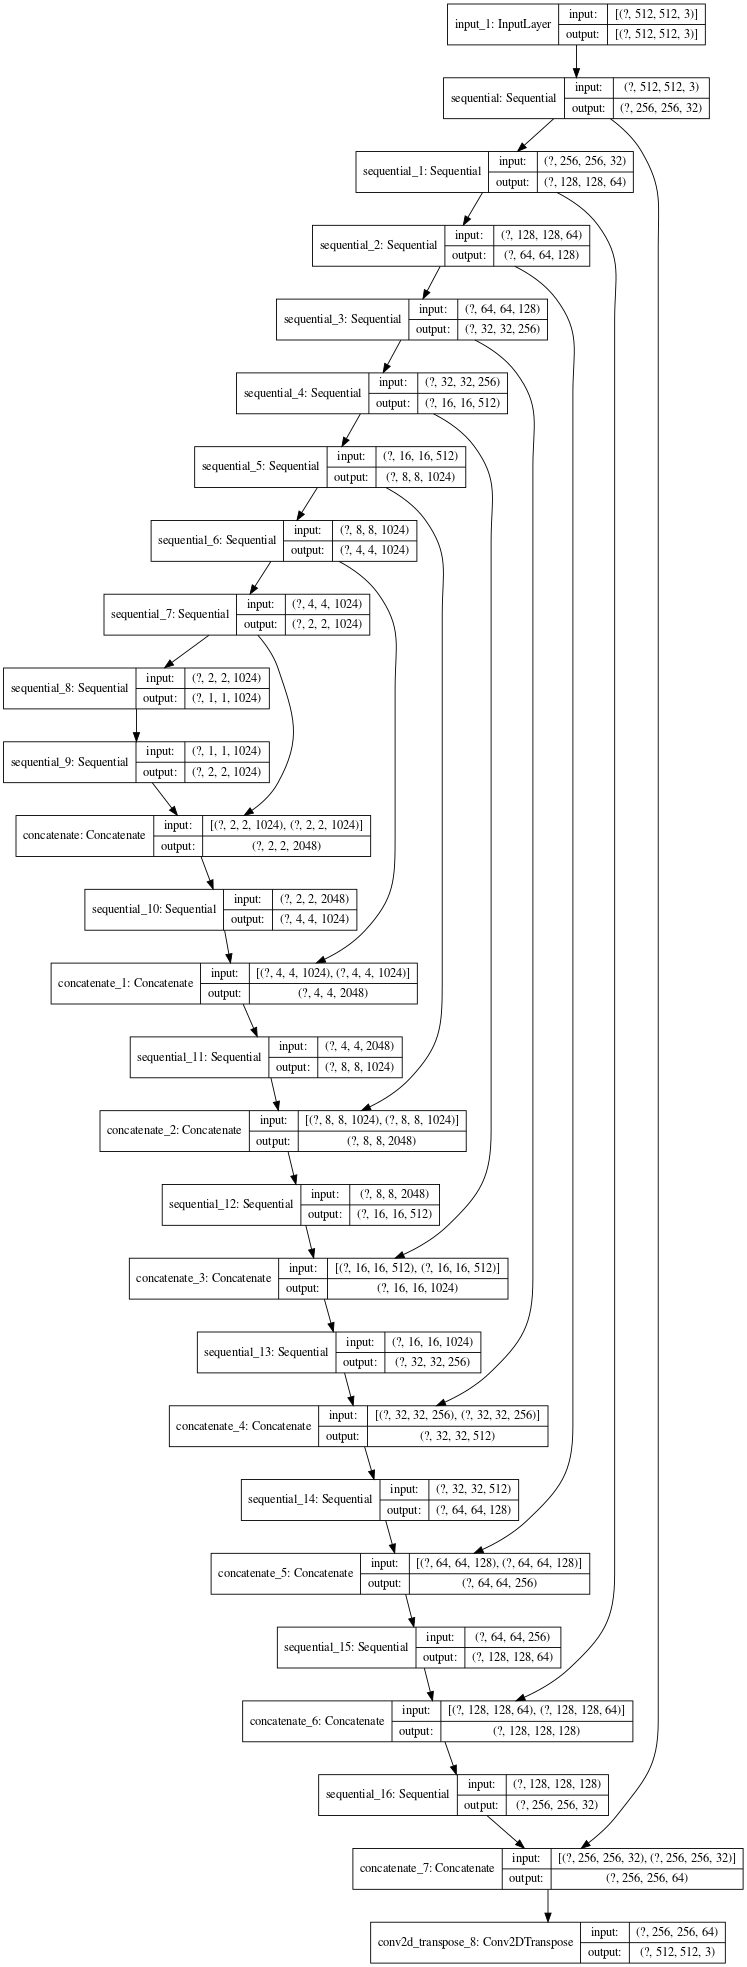

In [19]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

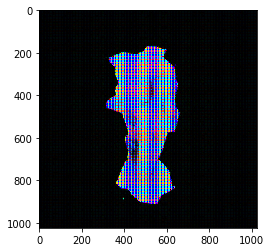

In [20]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [21]:
LAMBDA = 100

In [22]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss



![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

# <<<<<<<<<<<<<<<<

## Modified Discriminator for a tensor of 512x512

    I added two extra down sampling layers to the Discriminator, the layers:
    
    down1 = downsample(32, 4, False)(x) # (bs, 256, 256, 32) 
    ....
    ....
    ....
    down5 = downsample(512, 4)(down4) # (bs, 34, 34, 256)
    
    allowing the model to break down the tensor to the nessecery point of 
    (batch_size,30,30,1) and give a prediction.

# <<<<<<<<<<<<<<<<

In [23]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 512, 512, channels*2)

  down1 = downsample(32, 4, False)(x) # (bs, 256, 256, 32)  
  down2 = downsample(64, 4)(down1) # (bs, 128, 128, 64)
  down3 = downsample(128, 4)(down2) # (bs, 64, 64, 128)
  down4 = downsample(256, 4)(down3) # (bs, 32, 32, 256)
  down5 = downsample(512, 4)(down4) # (bs, 34, 34, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 31, 31, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

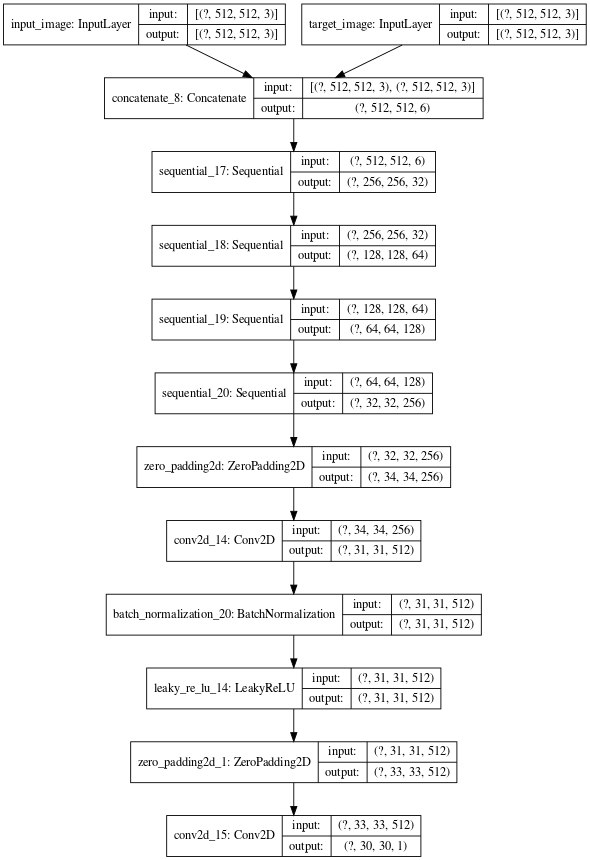

In [24]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

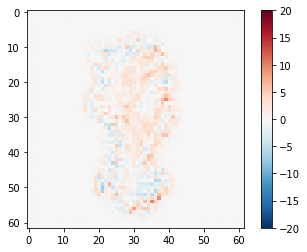

In [25]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=True)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [26]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).


![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver




In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [30]:
def generate_images(model, test_input, tar, num):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    
  savePath = 'generateIMG/'+str(num)+'.png'
  plt.savefig(savePath)  
  plt.show()

  

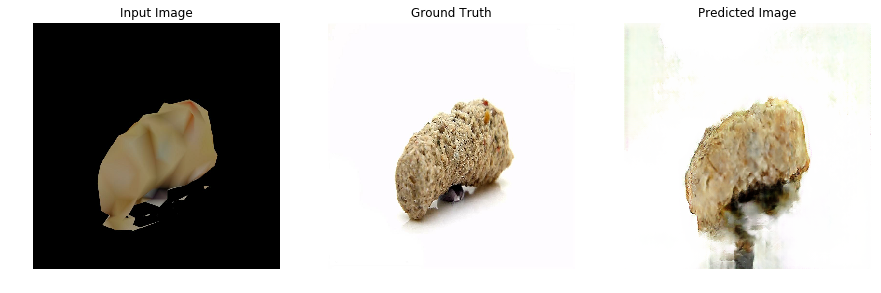

In [42]:
genNum = int(0)

for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target, genNum)
  genNum+=1



## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [33]:
EPOCHS = 200

In [34]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [35]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [36]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
        generate_images(generator, example_input, example_target,epoch)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
        print('.', end='')
        if (n+1) % 100 == 0:
            print()
            train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [49]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Restore the latest checkpoint:

In [37]:
!ls {checkpoint_dir}
print(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint		     ckpt-21.data-00001-of-00002
ckpt-21.data-00000-of-00002  ckpt-21.index
./training_checkpoints/ckpt-21


In [38]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


## Run the training loop:

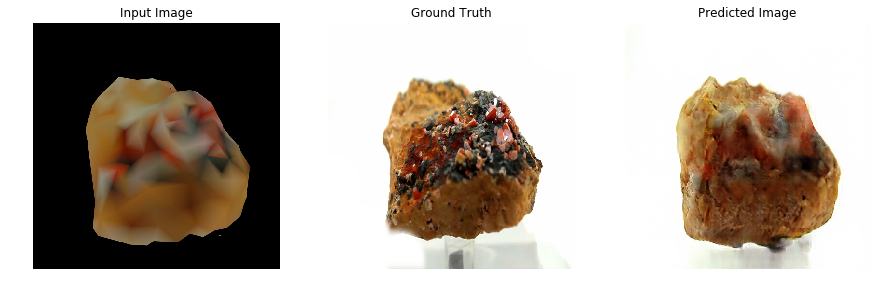

Epoch:  0
....................................................................................................
....................................................................................................
...........................................................................................

KeyboardInterrupt: 

In [43]:

fit(train_dataset, EPOCHS, test_dataset)

##  A quick and dirty save function for examples 

In [52]:
def save_images(model, test_input, tar, picnum):
  prediction = model(test_input, training=True)
  

  display_list = [test_input[0], tar[0], prediction[0]]
  #for i in range(3):
  plt.figure(figsize=(10,10))
  #plt.subplot(1, 3, 1)
  #plt.title(title[2])
  # getting the pixel values between [0, 1] to plot it.
  plt.imshow(display_list[2] * 0.5 + 0.5)
  plt.axis('off')
  savePath = 'Animation/Rand/'+str(picnum)+'.png'
  plt.savefig(savePath)

  plt.show()

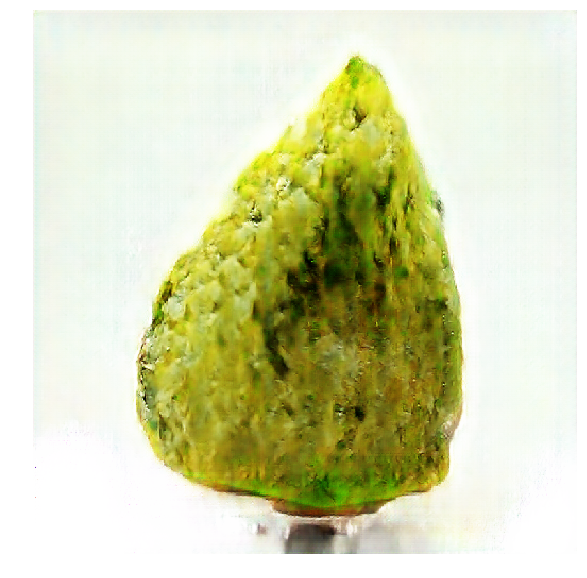

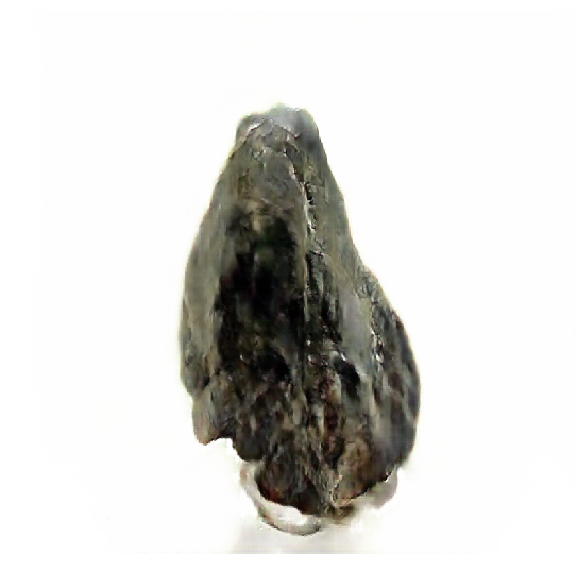

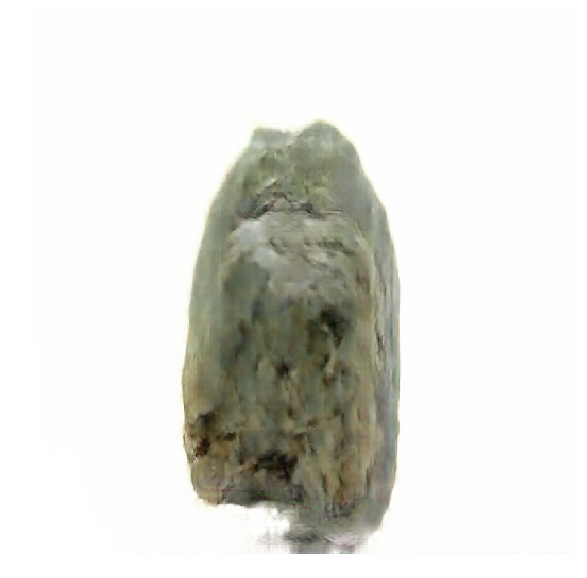

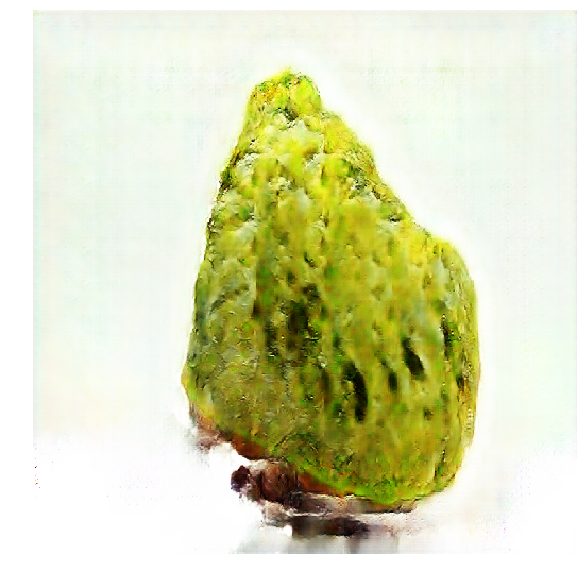

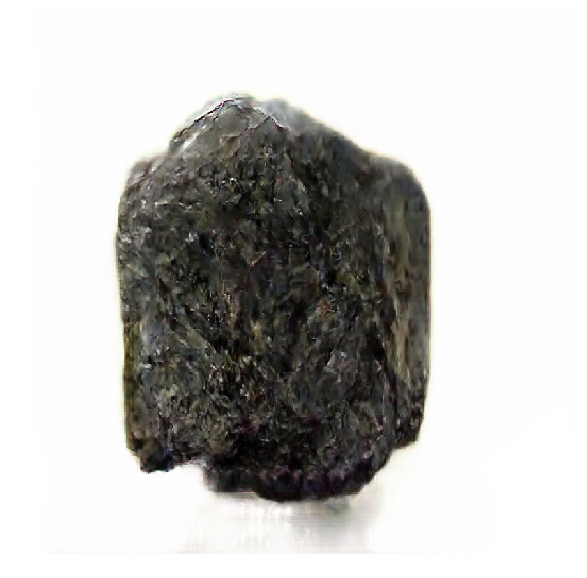

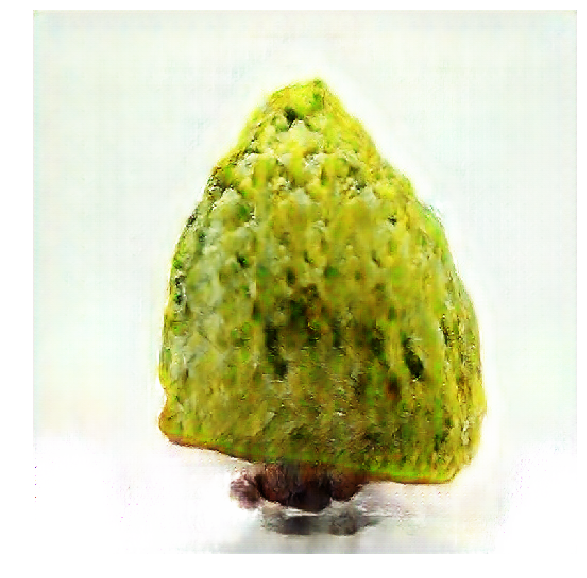

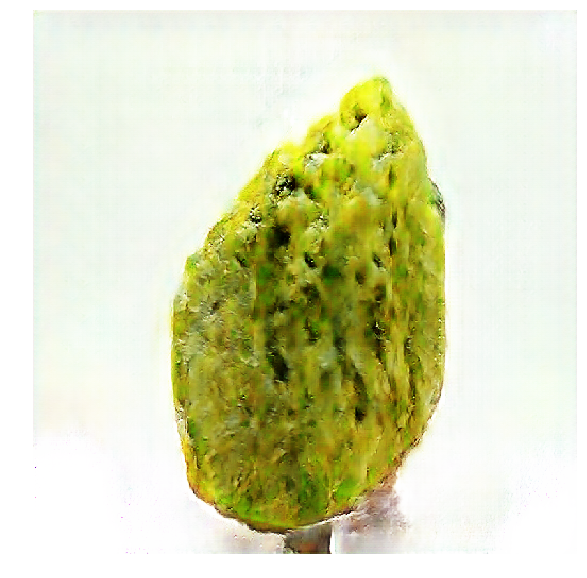

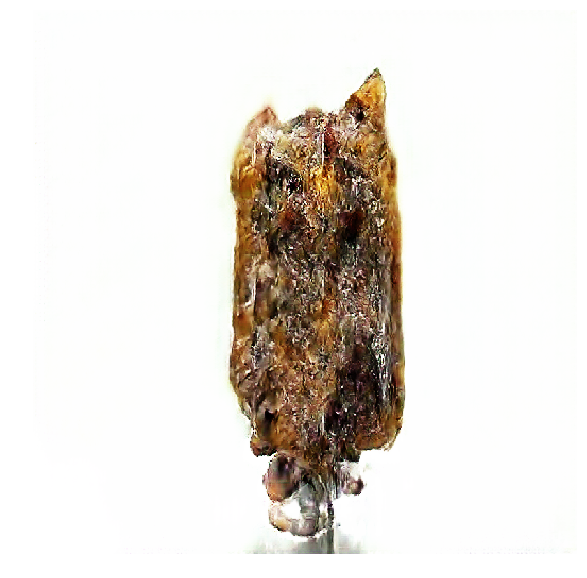

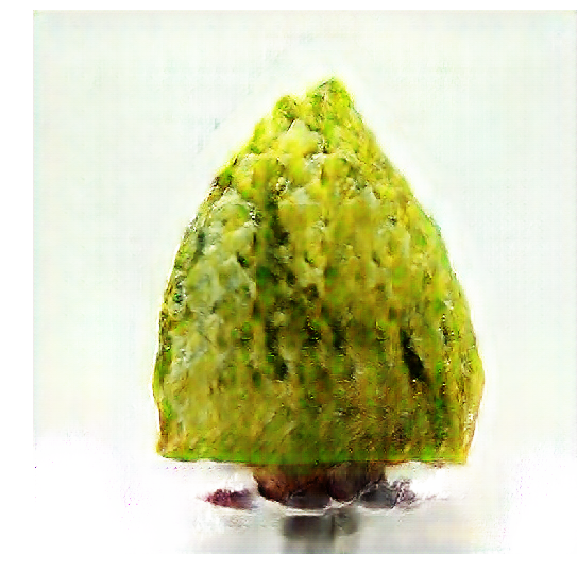

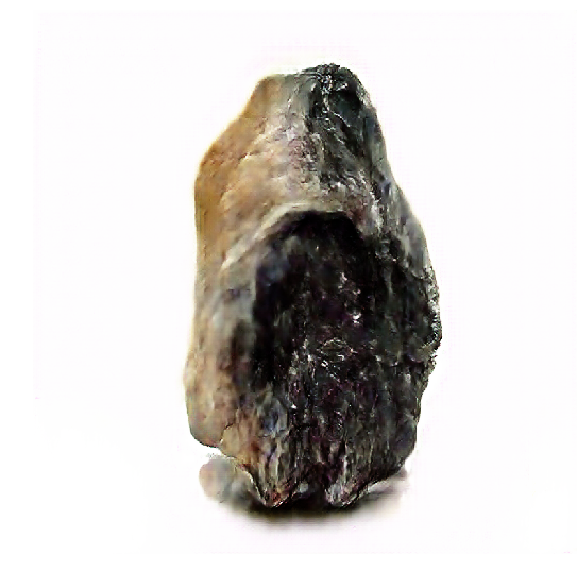

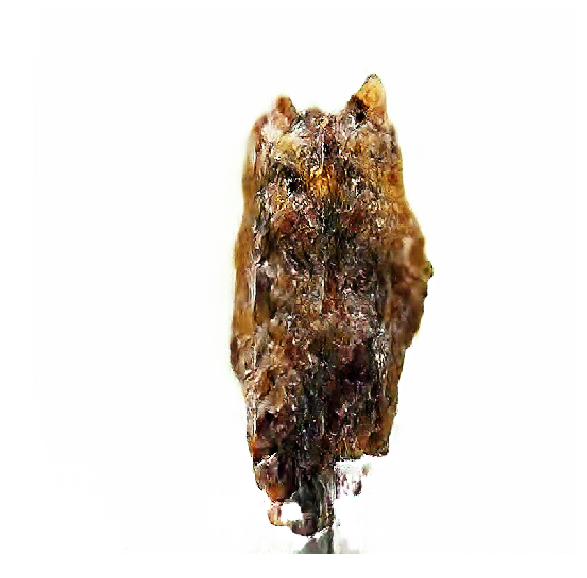

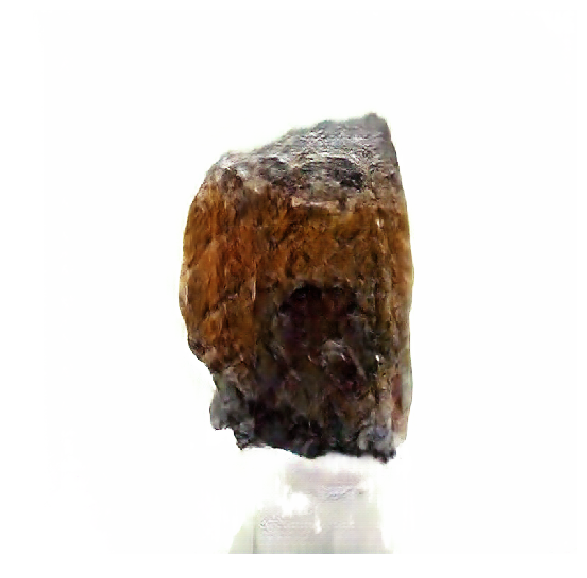

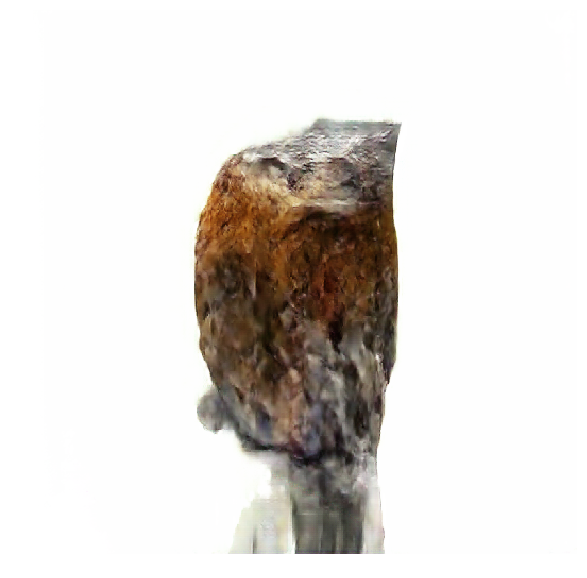

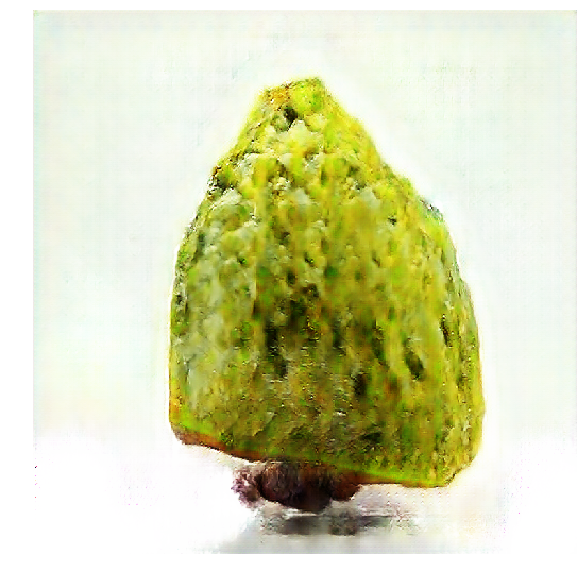

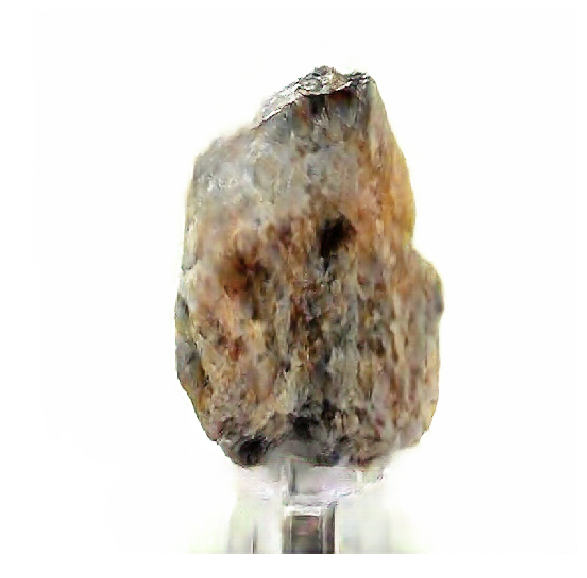

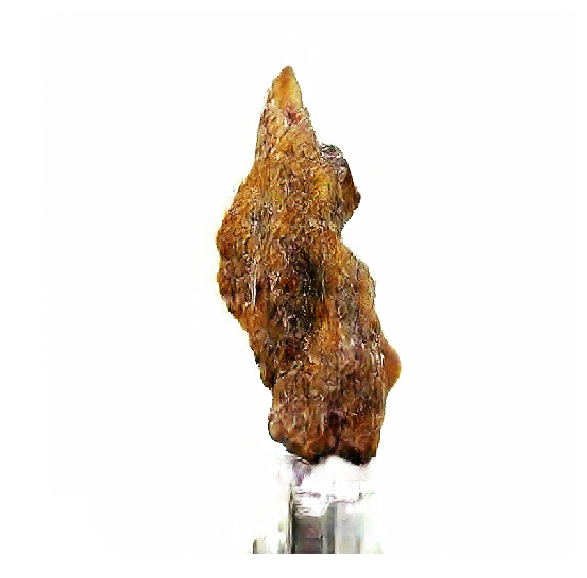

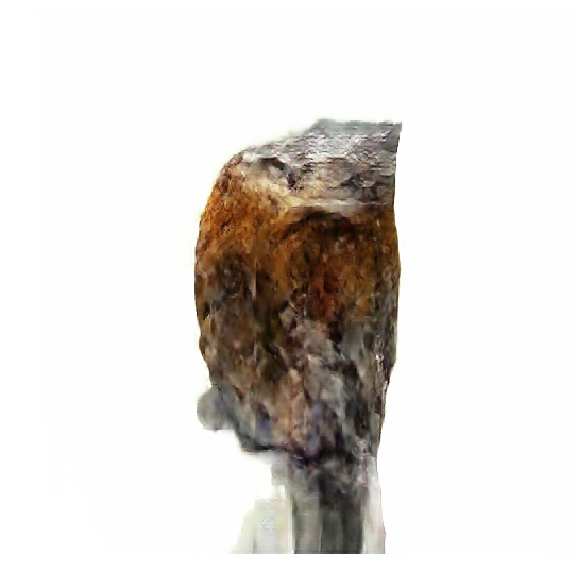

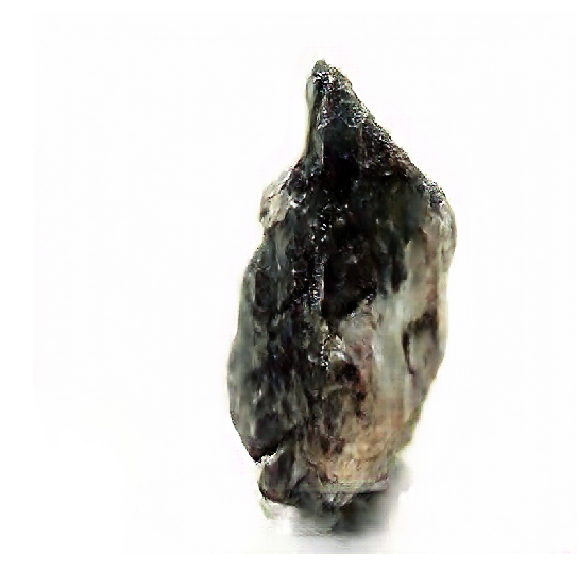

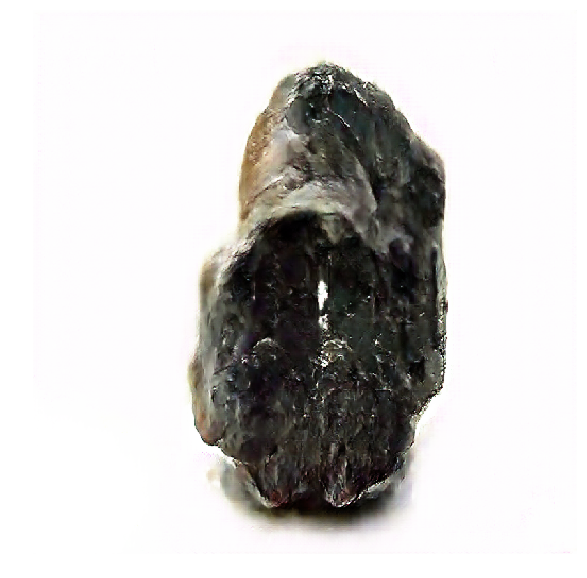

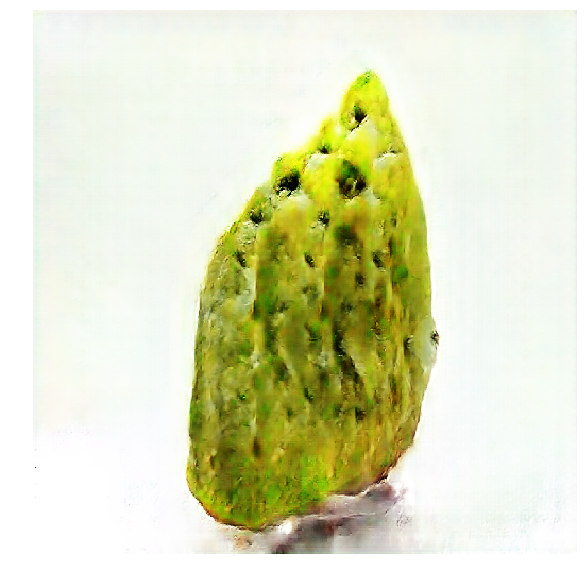

In [53]:
num = int(0)
for inp, tar in test_dataset.take(20):
  save_images(generator, inp, tar, num)
  num=num+1